# ABBA-BABA Test on 3R 24mb
Performed on:

  
  - Kenya population  <b>((([ <i>An.gambiae <sub>pops</sub></i> ], [<i>An.coluzzii <sub>pops</sub></i> ]), Kenya), [ <i>An.christyi</i> ])</b>
  - Far-west pops <b>((([ <i>An.gambiae <sub>pops</sub></i> ], [<i>Far-West<sub>pops</sub></i> ]]),  <i>An.coluzzii  <sub>pops</sub></i> ), [ <i>An.christyi</i> ])</b>
  
In the last part of the notebook also testing Kenya vs merus and melas populations

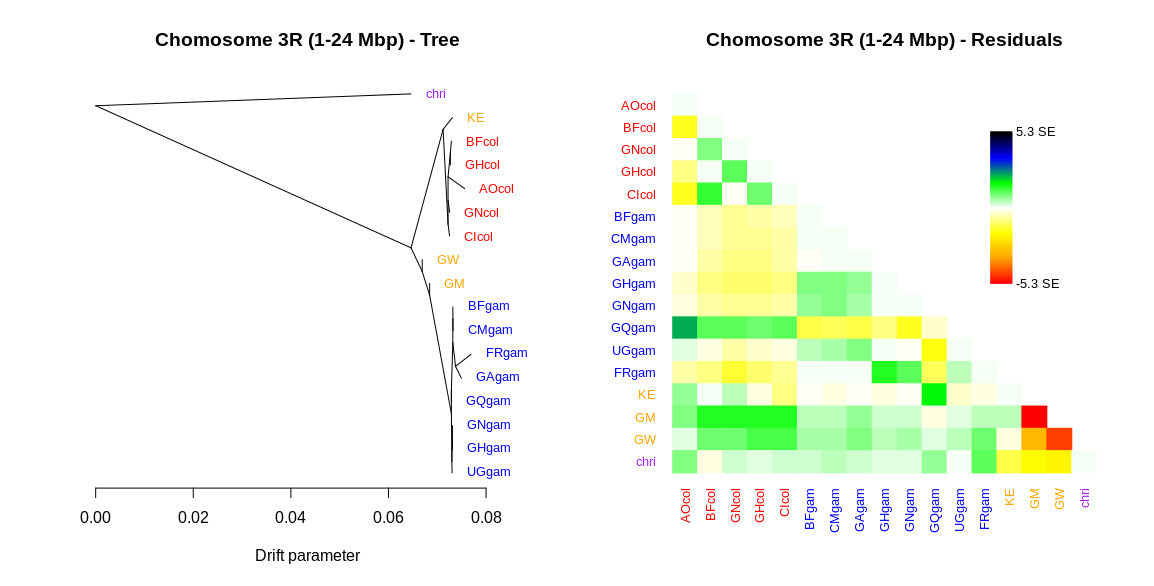

In [222]:
Image(filename='data/Treemix_data/christyi/3R_1-24mbp/Rplot.png')

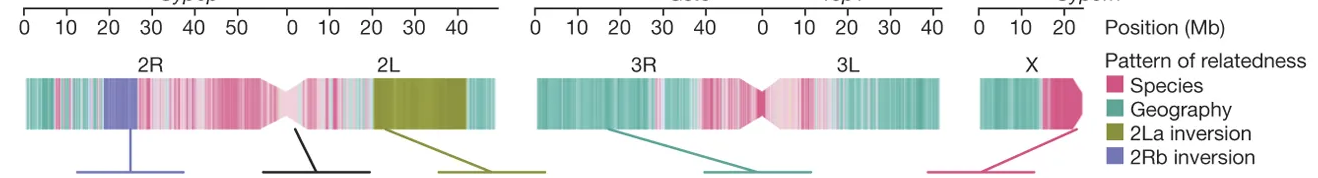

In [231]:
Image(filename='images/Schermata del 2019-12-18 15-14-23.png')

In [85]:
%run imports.ipynb
%run '08222019_functions.ipynb'
import allel
import zarr
import pandas as pd
import petl as etl
import numpy as np
import matplotlib.pyplot as plt
import dask.array as da
import seaborn as sns
from IPython.display import Image
palette = sns.color_palette()

In [86]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=30)
cluster

/opt/conda/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [87]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://10.35.63.174:34749 Dashboard: /user/carlo%20mariade%20marco1/proxy/43523/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [88]:
calldata_out= zarr.open('data/outgroup_alleles_phase2.zarr/')
calldata_biallel= zarr.open('data/phase2_biallel_allele_count.zarr/')

In [158]:
an_col = 'AOcol', 'BFcol', 'GNcol', 'CIcol', 'GHcol'
an_gam = 'GHgam', 'CMgam', 'BFgam', 'GNgam', 'GQgam', 'UGgam', 'GAgam', 'FRgam'
an_fw = 'GM', 'GW'
out_species = ['arab', 'chri', 'epir', 'mela', 'meru', 'quad']

In [90]:
def count_alleles_pos(chrom, start, stop):
    df_samples = pd.read_csv("samples.meta.txt", sep="\t")
    pos_all = allel.SortedIndex(callset_biallel[chrom]["variants/POS"])
    loc = pos_all.locate_range(start,stop)
    gt = allel.GenotypeDaskArray(callset_biallel[chrom]['calldata/GT'])
    subpops = metadata.groupby('population').indices
    ac_subpops = allel.AlleleCountsChunkedTable(gt[loc].count_alleles_subpops(subpops))
    return ac_subpops

In [91]:
ac_3R_24 = count_alleles_pos('3R', 1, 24_000_000)
ac_3R_24

<AlleleCountsChunkedTable shape=(5760020,) dtype=[('AOcol', '<i4', (2,)), ('BFcol', '<i4', (2,)), ('BFgam', '<i4', (2,)), ('CIcol', '<i4', (2,)), ('CMgam', '<i4', (2,)), ('FRgam', '<i4', (2,)), ('GAgam', '<i4', (2,)), ('GHcol', '<i4', (2,)), ('GHgam', '<i4', (2,)), ('GM', '<i4', (2,)), ('GNcol', '<i4', (2,)), ('GNgam', '<i4', (2,)), ('GQgam', '<i4', (2,)), ('GW', '<i4', (2,)), ('KE', '<i4', (2,)), ('UGgam', '<i4', (2,))]
   nbytes=703.1M
   values=builtins.dict>

In [92]:
loc = (allel.SortedIndex(callset_biallel['3R']["variants/POS"])).locate_range(1, 24_000_000)
loc

slice(0, 5760020, None)

In [93]:
ac_out_3R_24 = {pop: calldata_out['3R'][pop][loc] for pop in out_species}

In [94]:
ac_out_3R_24.keys()

dict_keys(['arab', 'chri', 'epir', 'mela', 'meru', 'quad'])

-------------------------------------------------------
## Perform the ABBA-BABA test
Using the old script

In [95]:
chromosomes = ['3R']

In [96]:
ac_cache = dict()

def load_ac(pop):
    if (pop) in ac_cache:
        return ac_cache[pop]
    else:
        if pop in out_species:
            ac = allel.AlleleCountsChunkedArray(ac_out_3R_24[pop])
        else:
            ac = ac_3R_24[pop]
            ac_cache[pop] = ac
        return ac
    
fourpop_cache = dict()

In [259]:
#this is the function that perform the test
def f4_analysis(A, B, C, D, blen=100000, plot=False, ax=None):
    
    key = (A, B, C, D, blen)
    if key in fourpop_cache:
        # re-use from cache
        d, d_se, d_z, d_vb, d_vj = fourpop_cache[key]
        
    else:
        # load allele counts
        aca = load_ac(A)
        acb = load_ac(B)
        acc = load_ac(C)
        acd = load_ac(D)

        # run D test
        d, d_se, d_z, d_vb, d_vj = allel.blockwise_patterson_d(aca, acb, acc, acd, blen=blen)
        
        # cache for re-use
        fourpop_cache[key] = d, d_se, d_z, d_vb, d_vj
    
    return d, d_se, d_z, d_vb, d_vj

#this is the function that give me to display multiple tests on a table
def f4_analyses(As, Bs, Cs, Ds, blen=100000):
    
    # normalise inputs
    if not isinstance(As, (list, tuple)):
        As = [As]
    if not isinstance(Bs, (list, tuple)):
        Bs = [Bs]
    if not isinstance(Cs, (list, tuple)):
        Cs = [Cs]
    if not isinstance(Ds, (list, tuple)):
        Ds = [Ds]
        
    # setup output table
    tbl = [['test', 'D', 'SE', 'Z']]
    for A in As:
        for B in Bs:
            if A != B:
                for C in Cs:
                    for D in Ds:
                        if C != D:
                            d, d_se, d_z, _, _ = f4_analysis(A, B, C, D, blen=blen)
                            test = '3R - 1-24Mbp  -  D(%s, %s; %s, %s)' % (A, B, C, D)
                            row = [test, d, d_se, d_z]
                            tbl += [row]
    
    return tbl

def tbl_display(tbl):
        # display results
    (etl
     .wrap(tbl)
     .interpolate('D', '%.3f')
     .interpolate('SE', '%.4f')
     .interpolate('Z', '%.1f')
     .displayall(index_header=False, 
                 tr_style=lambda row: 'background-color: %s' % ('#afa' if float(row.Z) > 5 else '#aaf' if float(row.Z) < -5 else 'white')))
    

    
def tbl_d_plot(table, title):
    # plot
    tbl = etl.wrap(table).sort('test')
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, tbl.nrows()*.2))
    
    ## First Plot - Bar Plot
    x = tbl.values('D').array()
    y = np.arange(tbl.nrows())
    ax1.axvline(0, color='r', lw=1)
    xerr = tbl.values('SE').array()
    ax1.errorbar(x, y, xerr=xerr, fmt='o', lw=1, color='k', mew=1, mfc='k')
    ax1.set_yticks(y)
    ylbls = ['%s; Z = %.1f' % (v.test, v.Z) for v in tbl.records()]
    ax1.set_yticklabels(ylbls)
    ax1.yaxis.tick_right()
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    ax1.set_xlim(-.2,.2)
    ax1.set_ylim(-1, y.size)
    ax1.grid(axis='both', color='#dddddd')
    ax1.set_xlabel("Patterson's $D$ Barplot")
    fig.suptitle('%s' % (title), y=1.02, fontsize=16)

    ## Second plot - Heatmap
    results = etl.todataframe(tbl)
    df1 = results[['test', 'D','Z']].round(2)
    heatmap1_data = pd.pivot_table(df1, values='Z', 
                     index=['test'], 
                     columns='D')
    lm = sns.heatmap(heatmap1_data, cmap="RdBu", vmin=15, vmax=-15, annot=True)
    ax2 = lm.axes
    ax2.set_xlim(-.7)
    ax2.set_ylim(40.4)
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    plt.xticks(rotation=70)
    ax2.set_xlabel("Patterson's $D$ Heatmap")
    ax2.invert_yaxis()
    plt.text(1.02, 0.5, 'Z-score', {'fontsize': 15},
             horizontalalignment='left',
             verticalalignment='center',
             rotation=90,
             clip_on=False,
             transform=plt.gca().transAxes)

    ax2.grid(False, 'major')
    ax2.grid(True, 'minor')
    ax2.set_yticks([t - 0.5 for t in ax2.get_yticks()], minor=True)
    sns.despine()
    fig.tight_layout()
    plt.show()  

In [260]:
A = an_gam
B = an_col
C = 'KE'
D = 'chri'
D_test = f4_analyses(A, B, C, D)

In [261]:
tbl_display(D_test)

test,D,SE,Z
"3R - 1-24Mbp - D(GHgam, AOcol; KE, chri)",-0.049,0.0127,-3.8
"3R - 1-24Mbp - D(GHgam, BFcol; KE, chri)",-0.021,0.0137,-1.6
"3R - 1-24Mbp - D(GHgam, GNcol; KE, chri)",-0.016,0.0131,-1.2
"3R - 1-24Mbp - D(GHgam, CIcol; KE, chri)",-0.024,0.0127,-1.9
"3R - 1-24Mbp - D(GHgam, GHcol; KE, chri)",-0.025,0.0131,-1.9
"3R - 1-24Mbp - D(CMgam, AOcol; KE, chri)",-0.047,0.0127,-3.7
"3R - 1-24Mbp - D(CMgam, BFcol; KE, chri)",-0.020,0.0137,-1.5
"3R - 1-24Mbp - D(CMgam, GNcol; KE, chri)",-0.015,0.0131,-1.1
"3R - 1-24Mbp - D(CMgam, CIcol; KE, chri)",-0.022,0.0127,-1.7
"3R - 1-24Mbp - D(CMgam, GHcol; KE, chri)",-0.024,0.0130,-1.8


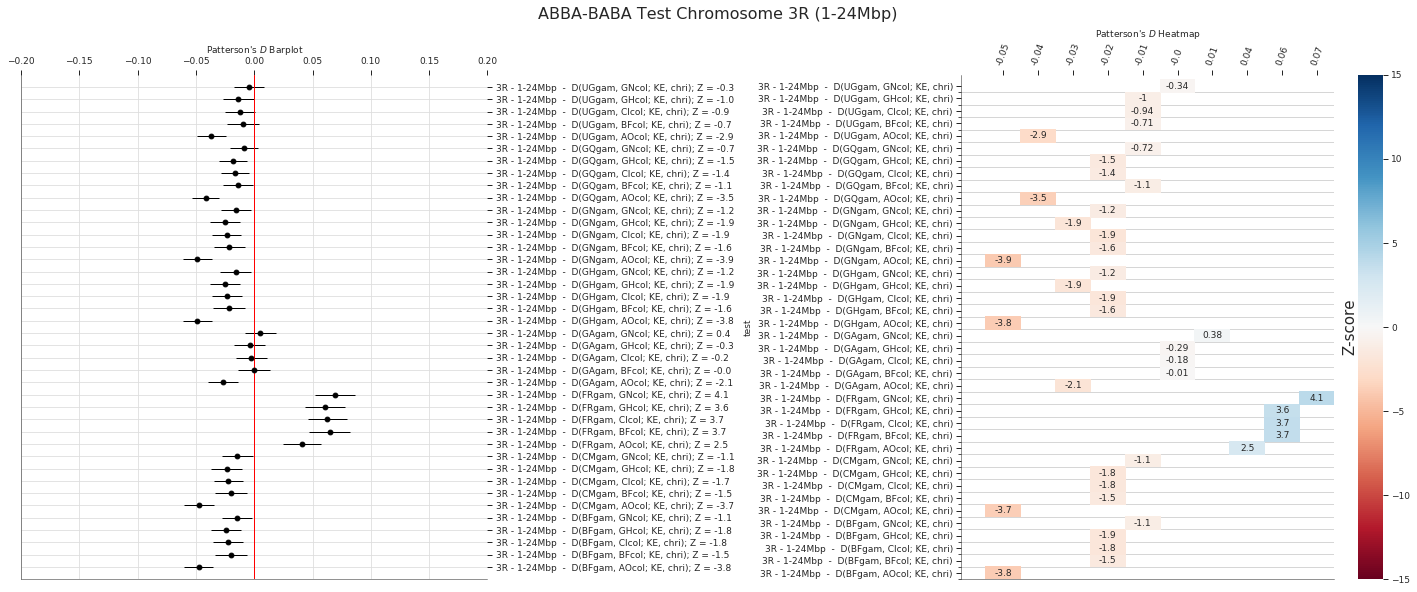

In [262]:
tbl_d_plot(D_test, 'ABBA-BABA Test Chromosome 3R (1-24Mbp)')

---------------------------

In [269]:
A = an_gam
B = an_fw
C = an_col
D = 'chri'
D_test = f4_analyses(A, B, C, D)

In [270]:
tbl_display(D_test)

test,D,SE,Z
"3R - 1-24Mbp - D(GHgam, GM; AOcol, chri)",0.008,0.0025,3.1
"3R - 1-24Mbp - D(GHgam, GM; BFcol, chri)",-0.019,0.0023,-8.3
"3R - 1-24Mbp - D(GHgam, GM; GNcol, chri)",-0.028,0.0029,-9.8
"3R - 1-24Mbp - D(GHgam, GM; CIcol, chri)",-0.026,0.0027,-9.5
"3R - 1-24Mbp - D(GHgam, GM; GHcol, chri)",-0.026,0.0027,-9.7
"3R - 1-24Mbp - D(GHgam, GW; AOcol, chri)",0.010,0.0030,3.3
"3R - 1-24Mbp - D(GHgam, GW; BFcol, chri)",-0.020,0.0028,-7.1
"3R - 1-24Mbp - D(GHgam, GW; GNcol, chri)",-0.031,0.0033,-9.3
"3R - 1-24Mbp - D(GHgam, GW; CIcol, chri)",-0.027,0.0032,-8.5
"3R - 1-24Mbp - D(GHgam, GW; GHcol, chri)",-0.028,0.0032,-8.6


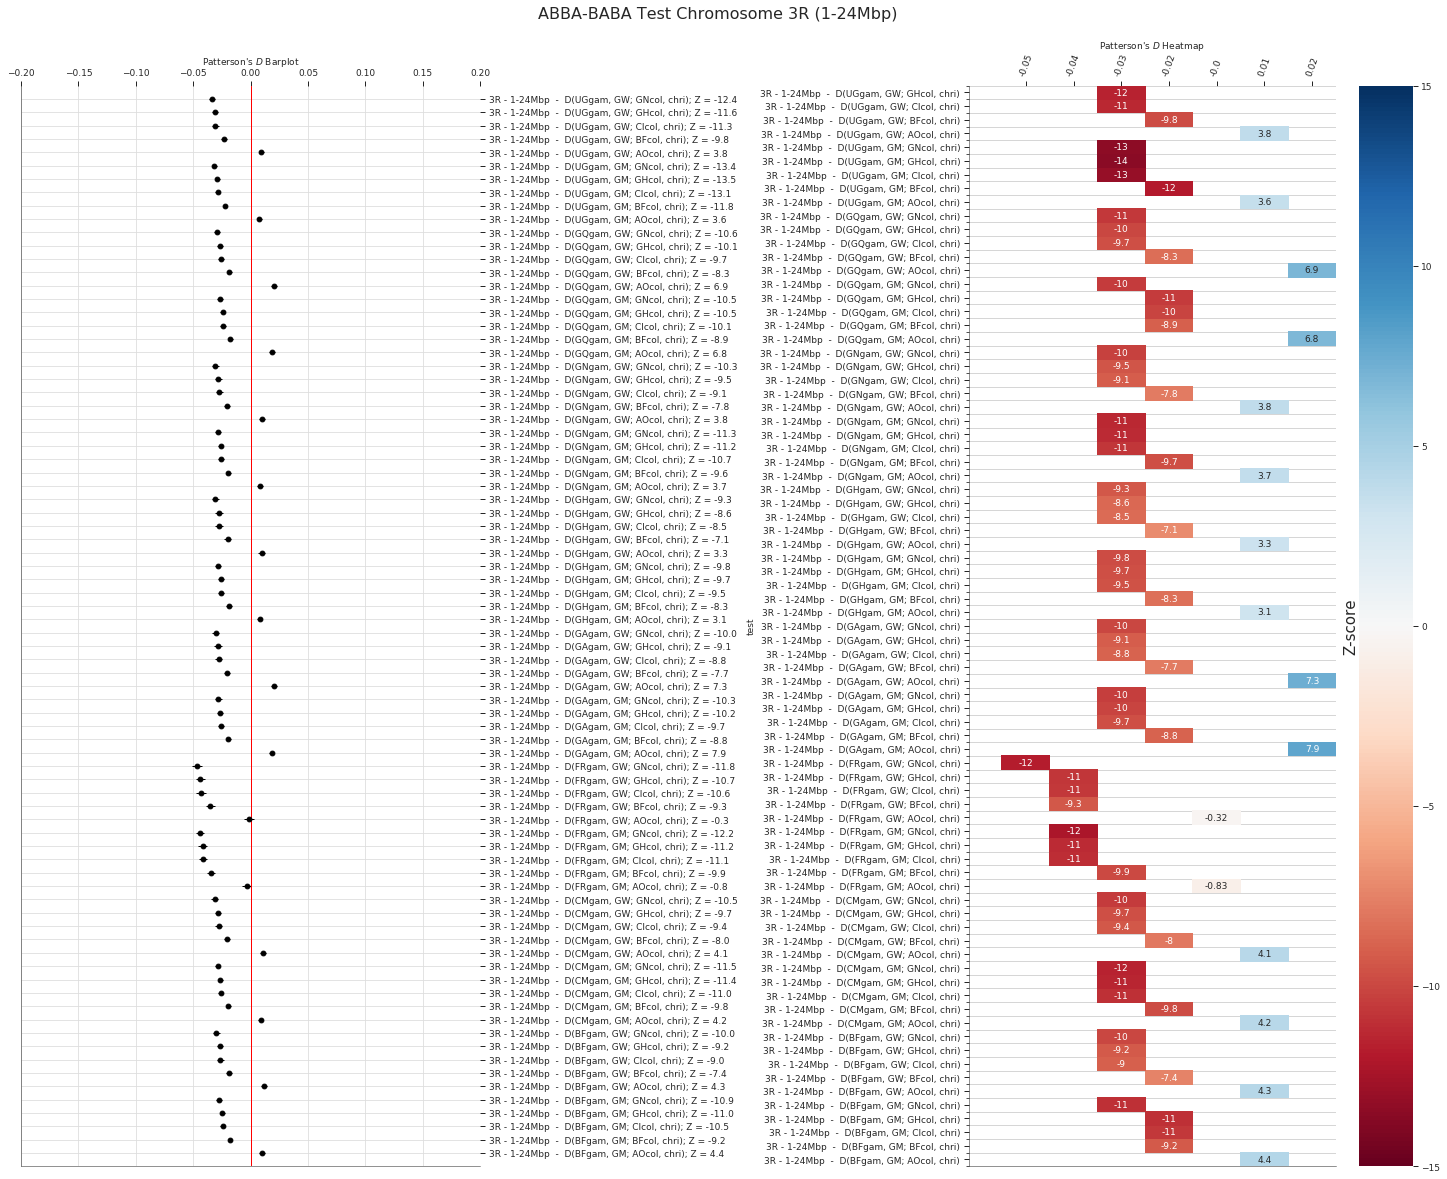

In [271]:
tbl_d_plot(D_test, 'ABBA-BABA Test Chromosome 3R (1-24Mbp)')

----------